In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt

from functools import partial

from pathlib import Path

In [2]:
from cxai import factory, inspector, constants, drsa
from cxai import utils as putils

# Introduction

This notebook reproduces Figure 2 in our paper on ["Disentangled Explanations of Neural Network Predictions by Finding Relevant Subspaces"][paper]. It demonstrates how to obtain disentangled explanations from PRCA and DRSA for class *basketball* of the Imagenet dataset. 

We use the Imagenet-pretrained VGG16 from TorchVision and LRP for produce explanations. 

We construct [PRCA][prca] and [DRSA][drsa] from activation and context vectors from Layer Conv4_3. To aid the demonstration, we have pre-extracted these vectors from some 500 training images of class *basketball*. We provide them  at `./data/raw/n02802426`. We also provide the pre-extracted DRSA projection matrices optimized on these vectors.

[prca]: #Principal-Relevance-Subspace-Analysis-(PRCA):-Extracting-a-Maximally-Contributing-Subspace
[drsa]: #Disentangled-Relevant-Subspace-Analysis-(DRSA):-Extracting-Subspaces-for-Disentangled-Explanations

[paper]: http://coming.soon

## Variable Declaration

In [3]:
ARCH = "torchvision-vgg16-imagenet"
LAYER = "conv4_3"
ATTR_METHOD = "lrp"

ARCH_LAYER_SLUG = f"{ARCH}-{LAYER}"

NSID = "n02802426"
TOTAL_IMAGES = 4

NUMBER_SUBSPACES = 4

DATA_DIR = putils.parent_dir(constants.PACKAGE_DIR) / "data"

In [4]:
label = putils.imagenet.get_index_from_imagenet_id(NSID)
class_name = putils.imagenet.get_desc_from_imagenet_id(NSID)
NSID, label, class_name

('n02802426', 430, 'basketball')

In [5]:
model, (rc_transform, input_transform) = factory.make_model(ARCH)

## Data Exploration

We provide four training images of class *basketball*. We note that these images are part of the ImageNet dataset.

In [6]:
images = list(map(
    lambda i: putils.load_image(DATA_DIR / "images" / f"img-{i}.jpg"),
    range(4)
))

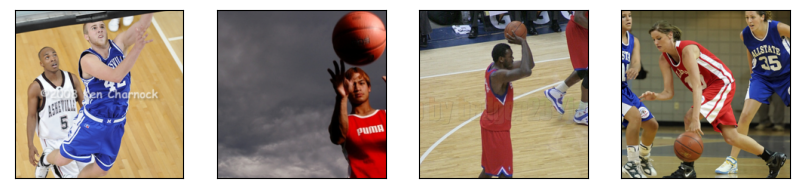

In [7]:
def visualize_images():
    
    ncols = TOTAL_IMAGES
    
    plt.figure(figsize=(2.5*ncols, 2.5))
    
    for i in range(ncols):
        plt.subplot(1, ncols, i+1)
        putils.viz.imshow(
            rc_transform(images[i])
        )
visualize_images()

# Standard Explanation

In [8]:
# instantiate an LRP-VGG16 explainer
explainer = factory.make_explainer("lrp", model)

/home/pat/projects/drsa-demo/venv/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


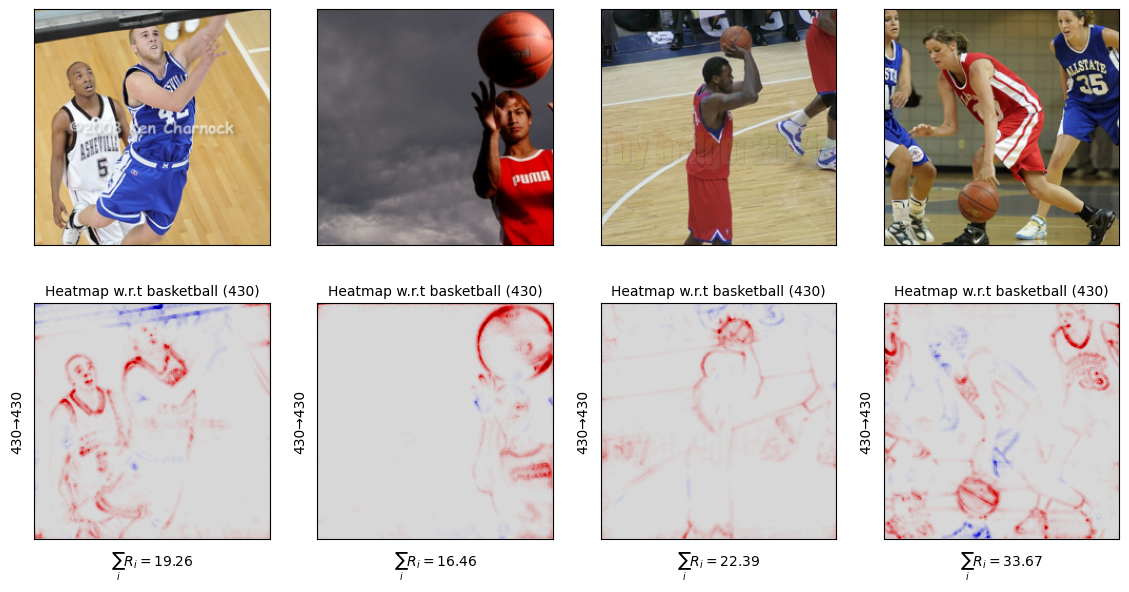

In [9]:
def visualize_standard_explanations():
    
    ncols = TOTAL_IMAGES
    nrows = 2
    
    plt.figure(figsize=(3.5*ncols, 3.5*nrows))
    
    for ix, img in enumerate(images):
        plt.subplot(nrows, ncols, ix+1)
        putils.viz.imshow(
            rc_transform(img)
        )
        
        # compute standard explanation
        logits, standard_heatmap = explainer.explain(
            input_transform(img),
            label,
        )

        pred_label = np.argmax(logits)
        
        # sum over channels
        standard_heatmap = standard_heatmap.sum(axis=0)

        plt.subplot(nrows, ncols, ncols + ix+1)

        putils.viz.heatmap(
            standard_heatmap,
            title=f"Heatmap w.r.t {class_name} ({label})"
        )
        plt.ylabel(f"{label}→{pred_label}")
        
visualize_standard_explanations()

# Principal Relevance Subspace Analysis (PRCA): Extracting a Maximally Contributing Subspace

Suppose $\mathcal D = \{(\boldsymbol a \in \mathbb{R}^d,\boldsymbol c \in \mathbb{R}^d)\}$ is a collection of activation and context<sup>1</sup> vectors extracted from 500 training images of class *basketball*. Recall the objective of PRCA 

$$
\max_U (U^\top \boldsymbol a)^\top (U^\top \boldsymbol c),
$$

where $U \in \mathbb{R}^{d \times d'}$ is a projection matrix with $U^\top U = I_{d'}$, and $d'$ is the number of dimensions chosen by the user. As shown in the paper, the optimization of PRCA  is equivalent to solve the eigenvalue problem of the symmetrized cross-correlation matrix

$$
   \Sigma_c = \mathbb{E}_{\mathcal D}[ \boldsymbol a \boldsymbol c^\top + \boldsymbol c \boldsymbol a^\top]. 
$$

In other words, the solution is the first $d'$ eigenvectors of $\Sigma_c$. Because of $\Sigma_c =\Sigma_c^\top$, we can use the function `eigh` to efficiently find these eigenvectos.

**Remark:** 1) We use LRP to produce the context vectors.

In [10]:
def extract_prca_projection_matrix(d_prime): 
    # load activation and context vectors
    mat_act = np.load(
        DATA_DIR / "raw" / NSID / "training-samples" / ARCH_LAYER_SLUG / "act.npy"
    )
    mat_ctx = np.load(
        DATA_DIR / "raw" / NSID / "training-samples" / ARCH_LAYER_SLUG / ATTR_METHOD / "ctx.npy" 
    )
    
    
    # compute the symmetrized cross-correlation matrix
    mat_cross_cov = (mat_act.T @ mat_ctx + mat_ctx.T @ mat_act) / mat_act.shape[0]
    
    # verify that the matrix is symmetric
    np.testing.assert_allclose(
        mat_cross_cov,
        mat_cross_cov.T
    )
    
    # compute the eigen decomposition of the matrix
    _, eigvecs =  np.linalg.eigh(mat_cross_cov)
    
    # in Numpy, the order of eigenvalues is in ascending.
    # Therefore, we have to reverse the order.
    eigvecs = eigvecs[:, ::-1].copy()
    
    # take the first d' eigenvectors
    eigvecs = eigvecs[:, :d_prime]
        
    return eigvecs

In [11]:
# shape: [d, d']
U_prca = extract_prca_projection_matrix(d_prime=1)

# Because the underlying implementation expect the shape of U to be [layer dimension (d), number of subspaces, subspace size (d')].
# We therefore add a dummy dimension in the 2nd dimension.
U_prca = U_prca[:, None, :]
U_prca.shape

(512, 1, 1)

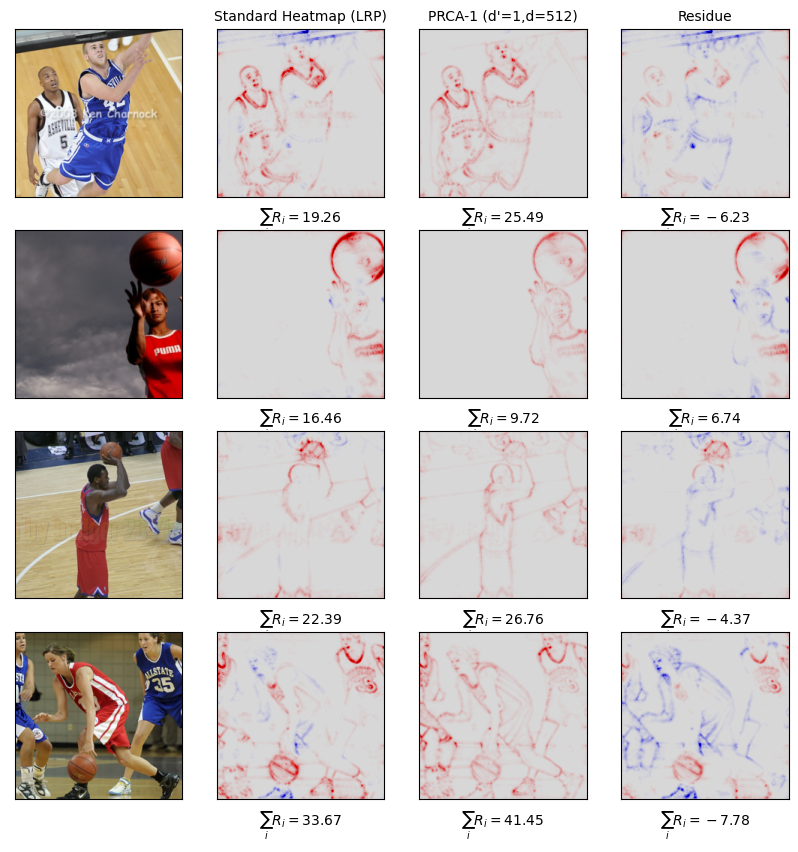

In [12]:
def visualize_prca_disentangled_explanations():
    
    # The inspector is an object that handles the projections of activation and context vectors
    # onto a given collection of projection matrices (U). 
    # In this case, the projection matrix is based on PRCA (U_prca)
    insp = inspector.GroupBasisInspector(
        layer=LAYER,
        weights=U_prca,
        verbose=False
    )
    
    d, d_prime = U_prca.shape[0], U_prca.shape[-1]
    
    
    ncols = 4
    nrows = len(images)
    plt.figure(figsize=(2.5*ncols, 2.5*nrows))

    
    for ix, img in enumerate(images):
        
        # produce subspace explanations with the defined inspector
        _, hm, info_prca = explainer.explain_with_inspector(
            input_transform(img),
            label,
            inspector=insp,
            # We set this to `1` because we have on only one subspace.
            top_k=1
        )

        hm = hm.sum(axis=0)

        plt.subplot(nrows, ncols, ncols*ix + 1)
        putils.viz.imshow(rc_transform(img))


        plt.subplot(nrows, ncols, ncols*ix + 2)
        putils.viz.heatmap(
            hm,
            title="Standard Heatmap (LRP)" if ix == 0 else ""
        )


        plt.subplot(nrows, ncols, ncols*ix + 3)
        putils.viz.heatmap(
            info_prca.input_top_k_source_heatmaps[0].sum(axis=0),
            title=f"PRCA-{d_prime} (d'={d_prime},d={d})" if ix == 0 else "",
            reference_heatmap=hm
        )

        plt.subplot(nrows, ncols, ncols*ix + 4)
        putils.viz.heatmap(
            info_prca.input_subspace_residue_heatmap.sum(axis=0),
            title=f"Residue" if ix == 0 else "",
            reference_heatmap=hm
        )
visualize_prca_disentangled_explanations()

# Disentangled Relevant Subspace Analysis (DRSA): Extracting Subspaces for Disentangled Explanations

Recall $\mathcal D = \{(\boldsymbol a \in \mathbb{R}^d,\boldsymbol c \in \mathbb{R}^d)\}$ the collection of activation and context vectors. Let $i \in \{n, \cdots, |\mathcal D | \}$ and $j \in \{1, \cdots, d\}$. We define

$$
\hat{\boldsymbol{a}}= \frac{1}{d^{1/4}}\frac{\boldsymbol{a}}{ \sqrt{\mathbb{E}_{n,j} [ a_{n,j}^2 } ]}, \quad \hat{\boldsymbol{c}}= \frac{1}{d^{1/4}}\frac{\boldsymbol{c}}{ \sqrt{\mathbb{E}_{n,j} [ c_{n,j}^2 } ]}.
$$

Denote $U_k \in \mathbb{R}^{d\times d'_k}$ with $\sum_k d'_k = d$ and $\boldsymbol{U} = (U_k)_k$ to be the column-wise concatenation of $U_k$'s with the constraint $\boldsymbol U^\top \boldsymbol U=  I$. Denote also $K$ to be the number of subspaces chosen by the user and $\mathcal K = \{1, \dots, K \}$.

Define the following to be the positive part of the projected relevance of sample $n$ on Subspace $k$:
 
$$
R_k^{(n)}(\boldsymbol{U}) = \max(0, (U_k^\top \boldsymbol a_n)^\top (U_k^\top \boldsymbol c_n)).
$$

The objective of DRSA is given by

$$
\max_{\boldsymbol U} \mathbb{M}^{0.5}_{k \in \mathcal K} \mathbb{M}^{2}_{n \in \mathcal D}[ R_k^{(n)}(\boldsymbol{U})] \quad  \text{subject to:}\ \boldsymbol{U}^\top \boldsymbol{U}= I_d,
$$

where $\mathbb{M}^p$ denotes the generalized F-mean with function $F(t) = t^p$, i.e. $
\mathbb{M}^p(\{x_i\}) = ({\sum_i x_i^p})^{1/p}
$. Specifically, one can interpret $\mathbb{M}^2$ and $\mathbb{M}^{0.5}$ as soft max- and min-pooling respectively. 


As described in the paper, we find $\boldsymbol{U}$ by using an iterative procedure in which we alternate between
1. gradient ascent on the objective,
2. orthogonalization of the solution at each iteration.

**Remarks:**
1. Due to non-convexity, we select the best solution out from 3 different initializations;
2. We reorder the $K$ subspaces based on their expected relevance, i.e.
$\mathbb{E}_{\mathcal D}[(U_k^\top \boldsymbol a)^\top (U_k^\top \boldsymbol c) ]$.

In [13]:
def extract_drsa_projection_matrices(
    use_preextracted=True,
    device="cpu",
    num_subspaces=NUMBER_SUBSPACES,
    seed=1,
    epochs=2500
):
    
    # Whether use pre-extracted DRSA subspaces
    if use_preextracted:
        preextracted_weights_path = DATA_DIR / "raw" / NSID / "training-samples" / ARCH_LAYER_SLUG / ATTR_METHOD / "bases" / "drsa-ns4-ss128-sm2-seed1" / "weights.npy"
        
        return np.load(preextracted_weights_path)

    # load activation and context vectors
    mat_act = np.load(
        DATA_DIR / "raw" / NSID / "training-samples" / ARCH_LAYER_SLUG / "act.npy"
    )
    mat_ctx = np.load(
        DATA_DIR / "raw" / NSID / "training-samples" / ARCH_LAYER_SLUG / ATTR_METHOD / "ctx.npy" 
    )
    
    d = mat_act.shape[1]
    
    # We assume that each subspace has the same number of dimensions
    d_prime = d // num_subspaces
    
    print(f"Training DRSA with {num_subspaces} {d_prime}-dimensional subspaces (d={d}, seed={seed})")

    # We do this normalization because activation and context vectors
    # from different layers are likely to have different magnitudes.
    # This normalization therefore stabilize the training.
    mat_act = mat_act / ((np.mean(mat_act**2) ** (1 / 2)) * (d ** (1 / 4)))
    mat_ctx = mat_ctx / ((np.mean(mat_ctx**2) ** (1 / 2)) * (d ** (1 / 4)))
    
    mat_act = torch.from_numpy(mat_act).to(device)
    mat_ctx = torch.from_numpy(mat_ctx).to(device)
    
    
    #  optimizatize the objective of DRSA
    (
        best_obj,
        U_drsa,
        best_obj_values,
    ) = drsa.optimize(
        obj_func=drsa.obj_drsa,
        act=mat_act,
        ctx=mat_ctx,
        seed=seed,
        ns=num_subspaces,
        ss=d_prime,
        epochs=epochs,
        device=device,
    )
    
    
    # reorder learned subspaces based on their expected relevance
    U_drsa = U_drsa.reshape((d, num_subspaces, d_prime))
        
    relevence_on_U = (
        torch.einsum("nd,dij->nij", mat_act,U_drsa) * torch.einsum("nd,dij->nij", mat_act, U_drsa)
    )
    relevence_on_U = relevence_on_U.sum(axis=2)  
    mean_relevence_on_U = relevence_on_U.mean(axis=0)
    
    sorted_indices = torch.argsort(-mean_relevence_on_U)
    
    U_drsa = U_drsa.cpu().numpy()
    U_drsa = U_drsa[:, sorted_indices, :].copy()
    
    return U_drsa

In [14]:
#  Remark: Training on a CPU (Intel(R) i7@2.80GHz) takes approximately 4 minutes per trial.
U_drsa = extract_drsa_projection_matrices(use_preextracted=True)
U_drsa.shape

(512, 4, 128)

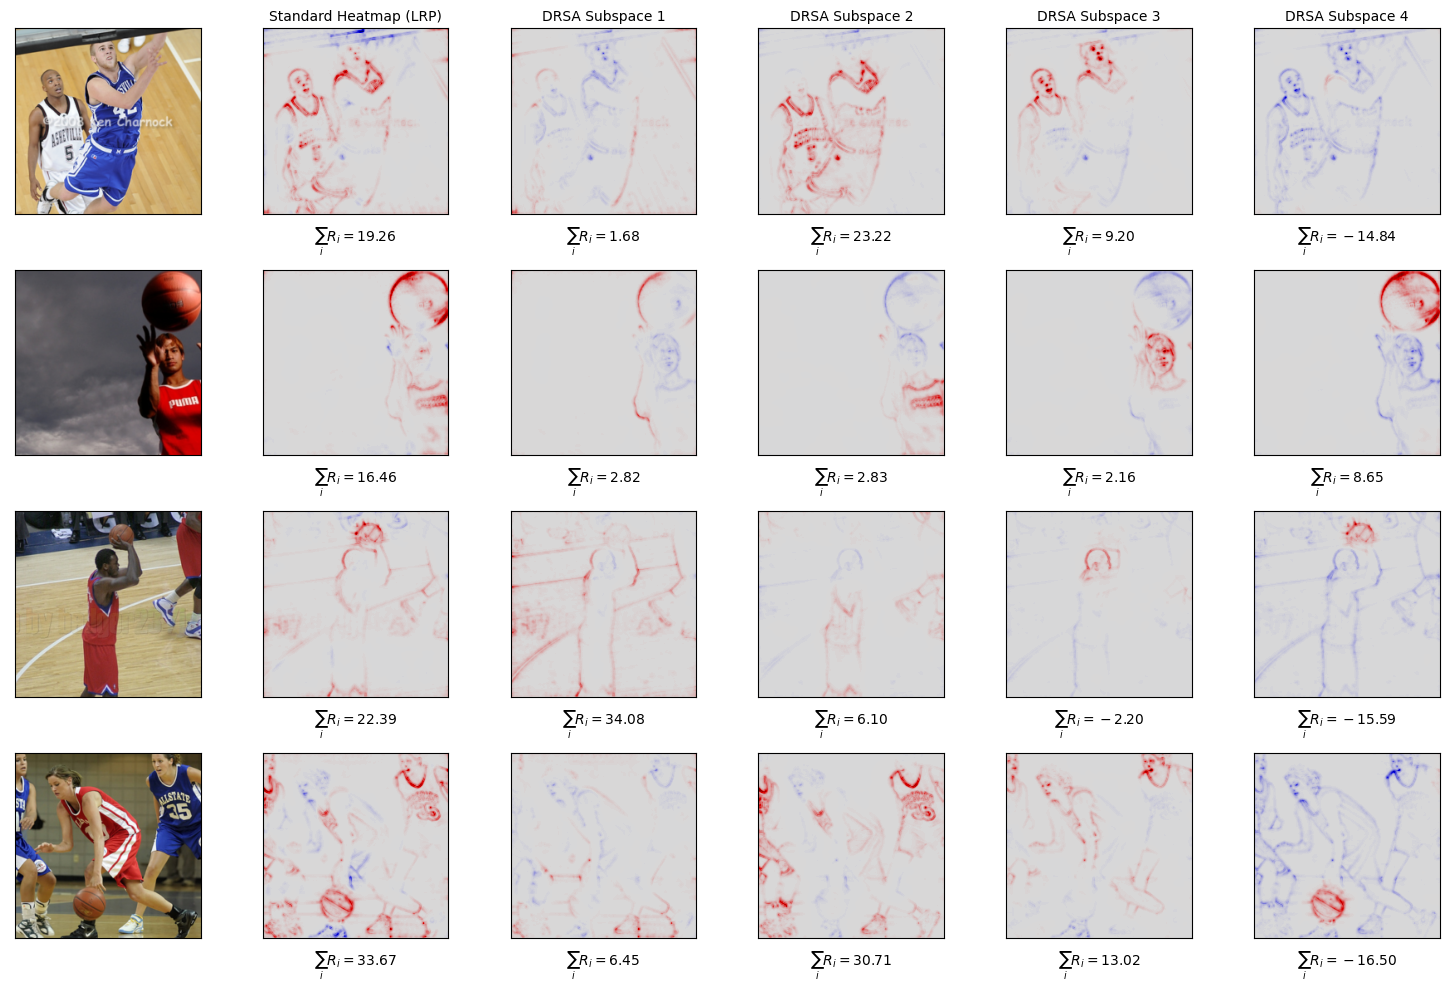

In [15]:
def visualize_drsa_disentangled_explanations():
    nrows = TOTAL_IMAGES
    ncols = 3 + NUMBER_SUBSPACES
    
    size = 2.5
    
    plt.figure(figsize=(size*ncols, size*nrows))
    
    
    for ix, img in enumerate(images):
        
        _, standard_heatmap, inspection_info = explainer.explain_with_inspector(
            input_transform(img),
            label,
            inspector=inspector.GroupBasisInspector(
                layer=LAYER,
                weights=U_drsa
            ),
            top_k=4
        )

        canonical_order = np.argsort(inspection_info.top_k_sources)
        subspace_heatmaps = inspection_info.input_top_k_source_heatmaps[canonical_order, :, :, :]

        # sum over channels
        subspace_heatmaps = subspace_heatmaps.sum(axis=1)
        standard_heatmap = standard_heatmap.sum(axis=0)

        plt.subplot(nrows, ncols, ix*ncols + 1)
        putils.viz.imshow(rc_transform(img))
        
        plt.subplot(nrows, ncols, ix*ncols + 2)
        putils.viz.heatmap(
            standard_heatmap,
            title=f"Standard Heatmap (LRP)" if ix == 0 else "",
        )
        
        # visualization
        for six in range(NUMBER_SUBSPACES):
            plt.subplot(nrows, ncols, ix*ncols + 3 + six)

            putils.viz.heatmap(
                subspace_heatmaps[six],
                title=f"DRSA Subspace {six+1}" if ix == 0 else "",
                reference_heatmap=standard_heatmap
            )
    plt.tight_layout()

visualize_drsa_disentangled_explanations()